<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [2]:
name = 'EMlocalization'
# Read the json info file
with open(f'4-data/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'4-data/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'4-data/{name}_target.parquet')


# Dynamical system

In [3]:
x_size = x_start.shape[1]

# # A pytorch module that multiplies the output of two other modules, where the two modules are given as arguments to the constructor, and the fo
# # The forward method takes a single argument and returns a single tensor.
# class Multiply(nn.Module):
#     def __init__(self, module1, module2):
#         super().__init__()
#         self.module1 = module1
#         self.module2 = module2
#     def forward(self, x):
#         return self.module1(x) * self.module2(x)

# map = Multiply(nn.Linear(x_size, x_size), nn.Linear(x_size, x_size)) 

map = nn.Sequential(nn.Linear(x_size, x_size), nn.LeakyReLU(), nn.Linear(x_size, x_size))

In [4]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

x_start_tensor_test = x_start_tensor[:100]
x_target_tensor_test = x_target_tensor[:100]

x_start_tensor = x_start_tensor[100:]
x_target_tensor = x_target_tensor[100:]
print(x_start_tensor.shape, x_start_tensor_test.shape)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

torch.Size([3160, 161]) torch.Size([100, 161])


In [5]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Rprop(map.parameters())

In [6]:
max_epochs = 2000
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 31, Loss 191212.859375


Epoch 100, Batch 31, Loss 108653.6875
Epoch 200, Batch 31, Loss 97327.015625
Epoch 300, Batch 31, Loss 104066.359375
Epoch 400, Batch 31, Loss 112637.7734375
Epoch 500, Batch 31, Loss 113036.4453125
Epoch 600, Batch 31, Loss 114630.03125
Epoch 700, Batch 31, Loss 112924.5
Epoch 800, Batch 31, Loss 125822.7265625
Epoch 900, Batch 31, Loss 138154.15625
Epoch 1000, Batch 31, Loss 107521.046875
Epoch 1100, Batch 31, Loss 138032.328125
Epoch 1200, Batch 31, Loss 135124.65625
Epoch 1300, Batch 31, Loss 129046.140625
Epoch 1400, Batch 31, Loss 132493.5625
Epoch 1500, Batch 31, Loss 162529.4375
Epoch 1600, Batch 31, Loss 191926.359375
Epoch 1700, Batch 31, Loss 100598.796875
Epoch 1800, Batch 31, Loss 131591.8125
Epoch 1900, Batch 31, Loss 118886.109375


# Training data

In [7]:
plot_idx = 2
mapped_tensor = map(x_start_tensor).detach()
print('before: ', x_start_tensor[plot_idx][-1])
print('after:  ', mapped_tensor[plot_idx][-1])
print('truth:  ', x_target_tensor[plot_idx][-1])



before:  tensor(18646.7461)
after:   tensor(19042.1367)
truth:   tensor(11112.7598)


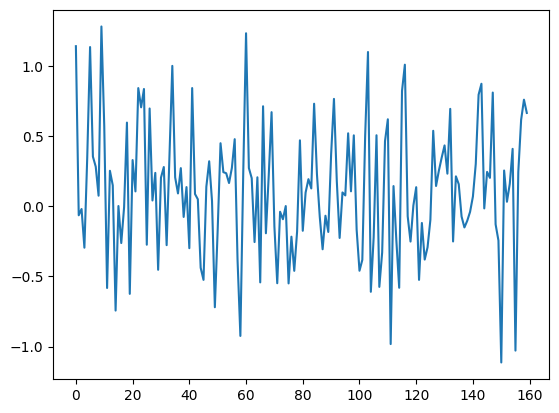

In [8]:
plt.figure()
plt.plot(mapped_tensor[plot_idx][:-1].numpy())

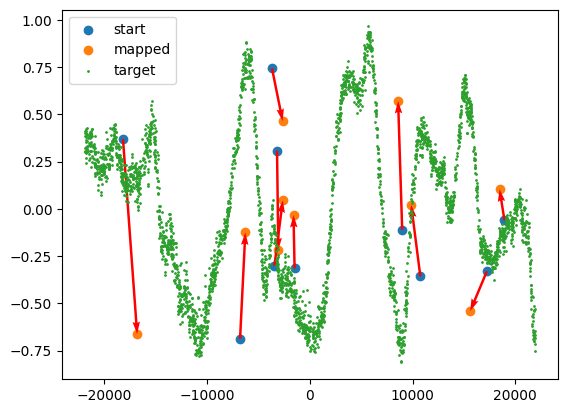

In [9]:
mapped_tensor = map(x_start_tensor).detach()
plot_points = 10

from sklearn.decomposition import PCA

def plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=2)
    pca.fit(x_target_tensor)
    # Project tensors to 2D using PCA
    x_start_tensor_2 = pca.transform(x_start_tensor)[:plot_points]
    mapped_tensor_2 = pca.transform(mapped_tensor)[:plot_points]
    x_target_tensor_2 = pca.transform(x_target_tensor)

    # Plot the 2D PCA projections and arrows
    fig, ax = plt.subplots()
    ax.scatter(x_start_tensor_2[:,0], x_start_tensor_2[:,1], label='start')
    ax.scatter(mapped_tensor_2[:,0], mapped_tensor_2[:,1], label='mapped')
    dx = mapped_tensor_2[:,0]-x_start_tensor_2[:,0]
    dy = mapped_tensor_2[:,1]-x_start_tensor_2[:,1]
    ax.quiver(x_start_tensor_2[:,0], x_start_tensor_2[:,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
    ax.scatter(x_target_tensor_2[:,0], x_target_tensor_2[:,1], s=1, label='target')
    plt.legend()
    plt.show()

# Plot the 2D PCA projections and arrows for the three tensors
plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points)

# Testing data

## Testing label

In [10]:
plot_idx = 2
test_tensor = x_start_tensor[plot_idx]
test_truth = x_target_tensor[plot_idx][-1]


for i in range(10):
    test_tensor[-1] = i*1000
    mapped_tensor = map(test_tensor).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)


before:  tensor(0.) after:   tensor(7651.6772) truth:  tensor(11112.7598)
before:  tensor(1000.) after:   tensor(8103.2524) truth:  tensor(11112.7598)
before:  tensor(2000.) after:   tensor(8554.3145) truth:  tensor(11112.7598)
before:  tensor(3000.) after:   tensor(9004.7891) truth:  tensor(11112.7598)
before:  tensor(4000.) after:   tensor(9454.7363) truth:  tensor(11112.7598)
before:  tensor(5000.) after:   tensor(9904.6514) truth:  tensor(11112.7598)
before:  tensor(6000.) after:   tensor(10354.4453) truth:  tensor(11112.7598)
before:  tensor(7000.) after:   tensor(10804.2217) truth:  tensor(11112.7598)
before:  tensor(8000.) after:   tensor(11254.) truth:  tensor(11112.7598)
before:  tensor(9000.) after:   tensor(11703.7754) truth:  tensor(11112.7598)


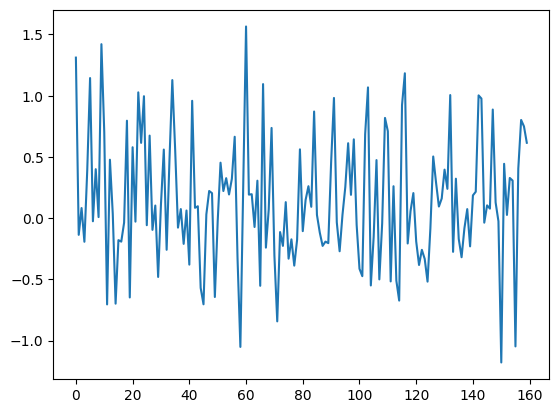

In [11]:
plt.figure()
plt.plot(mapped_tensor[:-1].numpy())

In [12]:
plot_idx = 155
test_tensor = x_start_tensor[plot_idx]
test_truth = x_target_tensor[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i*1000
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(55406.0039) truth:  tensor(18299.7598)
before:  tensor(1000.) after:   tensor(71436.7812) truth:  tensor(18299.7598)
before:  tensor(2000.) after:   tensor(72903.0859) truth:  tensor(18299.7598)
before:  tensor(3000.) after:   tensor(72139.4375) truth:  tensor(18299.7598)
before:  tensor(4000.) after:   tensor(69257.6328) truth:  tensor(18299.7598)
before:  tensor(5000.) after:   tensor(64385.8398) truth:  tensor(18299.7598)
before:  tensor(6000.) after:   tensor(58529.3359) truth:  tensor(18299.7598)
before:  tensor(7000.) after:   tensor(52463.4023) truth:  tensor(18299.7598)
before:  tensor(8000.) after:   tensor(46396.7617) truth:  tensor(18299.7598)
before:  tensor(9000.) after:   tensor(40330.2461) truth:  tensor(18299.7598)


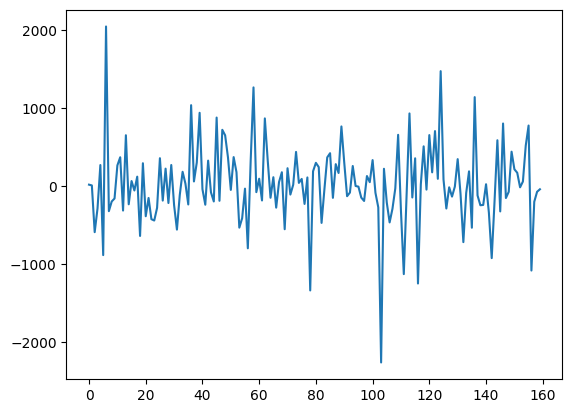

In [13]:
plt.figure()
plt.plot(mapped_tensor[:-1].numpy())

In [14]:
plot_idx = 0
test_tensor = x_start_tensor_test[plot_idx]
test_truth = x_target_tensor_test[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i*1000
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(13363.8154) truth:  tensor(16740.1992)
before:  tensor(1000.) after:   tensor(14118.6484) truth:  tensor(16740.1992)
before:  tensor(2000.) after:   tensor(11350.8691) truth:  tensor(16740.1992)
before:  tensor(3000.) after:   tensor(10270.1416) truth:  tensor(16740.1992)
before:  tensor(4000.) after:   tensor(10767.9150) truth:  tensor(16740.1992)
before:  tensor(5000.) after:   tensor(11086.9297) truth:  tensor(16740.1992)
before:  tensor(6000.) after:   tensor(11405.9727) truth:  tensor(16740.1992)
before:  tensor(7000.) after:   tensor(11723.7197) truth:  tensor(16740.1992)
before:  tensor(8000.) after:   tensor(12040.7979) truth:  tensor(16740.1992)
before:  tensor(9000.) after:   tensor(12354.5215) truth:  tensor(16740.1992)


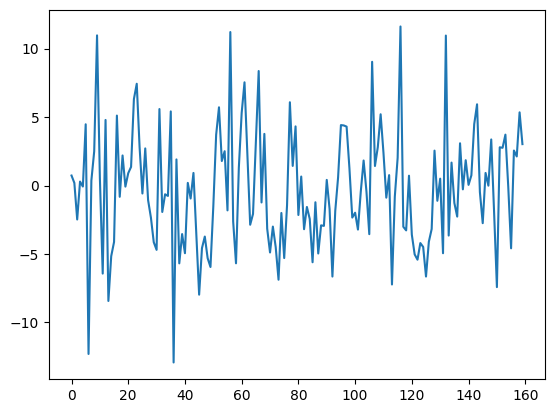

In [15]:
plt.figure()
plt.plot(mapped_tensor[:-1].numpy())

# Test all models

In [16]:
plot_idx = 1
test_tensor = x_start_tensor_test[plot_idx]
test_truth = x_target_tensor_test[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i*1000
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(26359.7480) truth:  tensor(47319.7305)
before:  tensor(1000.) after:   tensor(38759.0625) truth:  tensor(47319.7305)
before:  tensor(2000.) after:   tensor(40502.1602) truth:  tensor(47319.7305)
before:  tensor(3000.) after:   tensor(41722.5039) truth:  tensor(47319.7305)
before:  tensor(4000.) after:   tensor(40471.6328) truth:  tensor(47319.7305)
before:  tensor(5000.) after:   tensor(34822.9961) truth:  tensor(47319.7305)
before:  tensor(6000.) after:   tensor(29173.1660) truth:  tensor(47319.7305)
before:  tensor(7000.) after:   tensor(22997.9004) truth:  tensor(47319.7305)
before:  tensor(8000.) after:   tensor(16712.2324) truth:  tensor(47319.7305)
before:  tensor(9000.) after:   tensor(15398.1982) truth:  tensor(47319.7305)


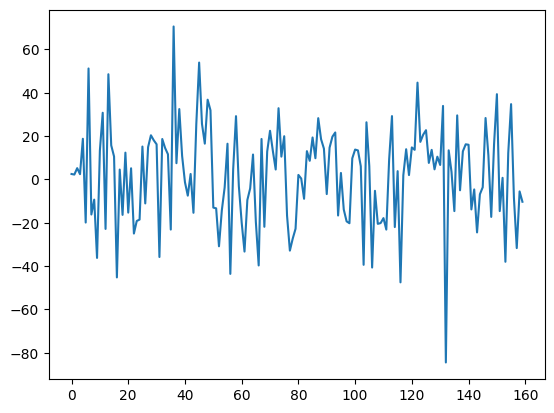

In [17]:
plt.figure()
plt.plot(mapped_tensor[:-1].numpy())